In [1]:
import laspy
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import Point
import random
from sklearn.preprocessing import StandardScaler

Read laz file, assign to pandas DataFrame

In [2]:
las_file = laspy.read("data/SaintLouisLiDAR.laz")

# Access scale and offset values
scale_x = las_file.header.scale[0]
offset_x = las_file.header.offset[0]
scale_y = las_file.header.scale[1]
offset_y = las_file.header.offset[1]
scale_z = las_file.header.scale[2]
offset_z = las_file.header.offset[2]

data = {
    "X": las_file.X * scale_x + offset_x,
    "Y": las_file.Y * scale_y + offset_y,
    "Z": las_file.Z * scale_z + offset_z,
    "intensity": las_file.intensity,
    "return_number": np.asarray(las_file.return_number),
    "number_of_returns": np.asarray(las_file.number_of_returns),
    "red": las_file.red,
    "green": las_file.green,
    "blue": las_file.blue
}
df = pd.DataFrame(data)
print(las_file.header.scale)
print(las_file.header.offset)
print(df.head())
print(df.isnull().sum())


len_data = len(las_file.points)

attributes_to_print = list(las_file.point_format.dimension_names)
attributes_to_print


# X,Y,Z, red, green, blue, intensity harici 0 tutmaktadır
# return_number ve number_of_returns 0 değil değişmektedir

[0.001 0.001 0.001]
[ 729000. 4301000.      -0.]
            X            Y        Z  intensity  return_number  \
0  729911.303  4301275.080  160.166      12592              2   
1  729911.981  4301275.055  160.212      12944              3   
2  729912.662  4301275.031  160.258      10848              3   
3  729913.355  4301275.006  160.283       8240              3   
4  729914.036  4301274.981  160.313      15968              1   

   number_of_returns    red  green   blue  
0                  2  17664  23296  17920  
1                  3  15872  22016  15872  
2                  3  18432  25344  17408  
3                  3  17920  24064  17920  
4                  1  17408  22528  18432  
X                    0
Y                    0
Z                    0
intensity            0
return_number        0
number_of_returns    0
red                  0
green                0
blue                 0
dtype: int64


['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue',
 'nir']

In [3]:
las_min_x, las_max_x = df["X"].min(), df["X"].max()
las_min_y, las_max_y = df["Y"].min(), df["Y"].max()

print("min and max values of points in las file")
print(f"Min X: {las_min_x}, Max X: {las_max_x}, range: {(las_max_x - las_min_x)}")
print(f"Min Y: {las_min_y}, Max Y: {las_max_y}, range: {las_max_y - las_min_y}")

min and max values of points in las file
Min X: 729885.001, Max X: 731385.0, range: 1499.9989999999525
Min Y: 4301246.001, Max Y: 4302745.999, range: 1499.9979999996722


In [6]:
range_y = las_max_y - las_min_y
limit_y = las_min_y + range_y * 0.5
train_df = df[df["Y"] < limit_y]
test_df = df[df["Y"] >= limit_y]
print(len(train_df), len(test_df))
print(len(df))

5419135 3817382
9236517


In [4]:
# print values of the first point
point = las_file.points[0]
print(f"X: {point.x}, Y: {point.y}, Z: {point.z}, Intensity: {point.intensity}, classification: {point.classification}, nir: {point.nir}, return_number: {point.return_number}, number_of_returns: {point.number_of_returns}, red: {point.red}, green: {point.green}, blue: {point.blue}")

X: <ScaledArrayView(729911.303)>, Y: <ScaledArrayView(4301275.08)>, Z: <ScaledArrayView(160.166)>, Intensity: 12592, classification: 0, nir: 0, return_number: <SubFieldView(2)>, number_of_returns: <SubFieldView(2)>, red: 17664, green: 23296, blue: 17920


In [5]:
# two other way to use the point
def extract_data(point):
    return {
        "X": getattr(point, "X"),
        "Y": getattr(point, "Y"),
        "Z": getattr(point, "Z"),
        "intensity": getattr(point, "intensity"),
        "return_number": getattr(point, "return_number"),
        "number_of_returns": getattr(point, "number_of_returns"),
        "red": getattr(point, "red"),
        "green": getattr(point, "green"),
        "blue": getattr(point, "blue"),
    }




len_data = len(las_file.points)
points = las_file.points
for i in range(5):
    rand = random.randint(0, len_data)
    point = points[i]
    print(", ".join([f"{attr}: {getattr(point, attr)}" for attr in attributes_to_print]))


X: 911303, Y: 275080, Z: 160166, intensity: 12592, return_number: <SubFieldView(2)>, number_of_returns: <SubFieldView(2)>, synthetic: <SubFieldView(0)>, key_point: <SubFieldView(0)>, withheld: <SubFieldView(0)>, overlap: <SubFieldView(0)>, scanner_channel: <SubFieldView(0)>, scan_direction_flag: <SubFieldView(0)>, edge_of_flight_line: <SubFieldView(0)>, classification: 0, user_data: 0, scan_angle: 0, point_source_id: 0, gps_time: 0.0, red: 17664, green: 23296, blue: 17920, nir: 0
X: 911981, Y: 275055, Z: 160212, intensity: 12944, return_number: <SubFieldView(3)>, number_of_returns: <SubFieldView(3)>, synthetic: <SubFieldView(0)>, key_point: <SubFieldView(0)>, withheld: <SubFieldView(0)>, overlap: <SubFieldView(0)>, scanner_channel: <SubFieldView(0)>, scan_direction_flag: <SubFieldView(0)>, edge_of_flight_line: <SubFieldView(0)>, classification: 0, user_data: 0, scan_angle: 0, point_source_id: 0, gps_time: 0.0, red: 15872, green: 22016, blue: 15872, nir: 0
X: 912662, Y: 275031, Z: 16025

In [6]:
x_values = df["X"]
x_values

0          729911.303
1          729911.981
2          729912.662
3          729913.355
4          729914.036
              ...    
9236512    731357.675
9236513    731357.281
9236514    731356.901
9236515    731356.525
9236516    731356.162
Name: X, Length: 9236517, dtype: float64

In [7]:
y_values = df["Y"]
y_values

0          4301275.080
1          4301275.055
2          4301275.031
3          4301275.006
4          4301274.981
              ...     
9236512    4302739.671
9236513    4302739.659
9236514    4302739.582
9236515    4302739.506
9236516    4302739.433
Name: Y, Length: 9236517, dtype: float64

In [8]:
print(len(points))
print(points[0].X)
print(type(points))
print(type(points[0]))

9236517
911303
<class 'laspy.point.record.ScaleAwarePointRecord'>
<class 'laspy.point.record.ScaleAwarePointRecord'>


In [9]:
shape_file = gpd.read_file("data/SaintLouisTrees/SaintLouisTrees.shp")
print(shape_file.head())
print()
print(shape_file.shape) # 22 polygon
print(type(shape_file))
print(shape_file.columns)

   id                                           geometry
0   0  POLYGON ((731303.807 4302697.494, 731301.270 4...
1   0  POLYGON ((731285.335 4302721.912, 731280.896 4...
2   0  POLYGON ((731193.691 4302745.378, 731198.765 4...
3   0  POLYGON ((731255.844 4302725.717, 731245.380 4...
4   0  POLYGON ((731225.402 4302733.327, 731214.620 4...

(22, 2)
<class 'geopandas.geodataframe.GeoDataFrame'>
Index(['id', 'geometry'], dtype='object')


[(731185.8428510817, 4302629.3161971895), (731184.8915286822, 4302621.388510525), (731176.329627085, 4302621.388510525), (731175.6954121514, 4302625.510907592), (731174.7440897516, 4302631.85305692), (731182.3546689496, 4302633.438594255), (731185.8428510817, 4302629.3161971895)]


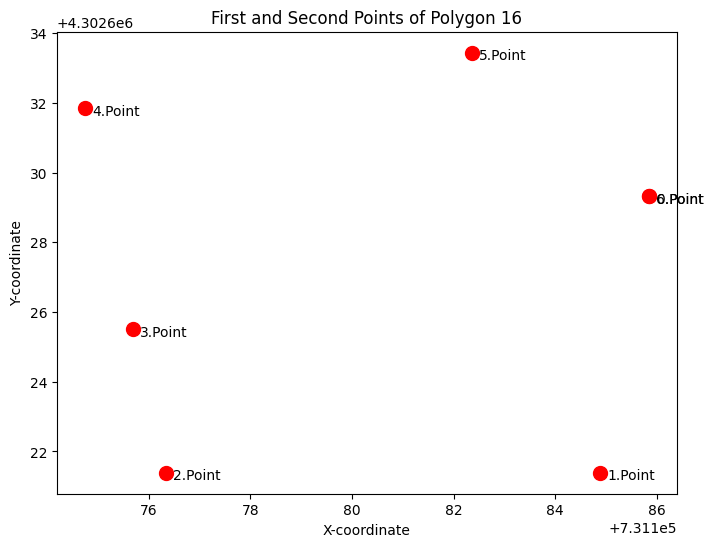

In [10]:
# plot the points of 17. polygon at index 16
shape_file.drop('id', axis=1, inplace=True)
list_16 = list(shape_file.loc[16, "geometry"].exterior.coords)
print(list_16)


# Create a plot
plt.figure(figsize=(8, 6))
for i in range(len(list_16)):
    plt.plot(list_16[i][0], list_16[i][1], 'o', color='red', markersize=10)
    plt.annotate(
        f"{i}." "Point",
        xy=(list_16[i][0], list_16[i][1]),
        xytext=(5, -5),
        textcoords='offset points',
    )
# Add labels and title
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("First and Second Points of Polygon 16")

# Show the plot
plt.show()



In [11]:
import cv2 as cv

# pixel values of png file is 0 or 220
# so we convert it to 0 or 1
# 0 means tree, 1 means not tree
ground_truth = cv.imread("data/SaintLouisTrees/SaintLouisTrees.png", cv.IMREAD_GRAYSCALE)
ret, thresh = cv.threshold(ground_truth, 127, 1, cv.THRESH_BINARY)
print(thresh.shape)


(3001, 3001)


In [12]:
ground_truth_size = ground_truth.shape[0]

min and max values of points in las file
Min X: 729885.001, Max X: 731385.0, range: 1499.9989999999525
Min Y: 4301246.001, Max Y: 4302745.999, range: 1499.9979999996722


In [13]:
def get_row_pixel_index_of_point(point_y):
    pixel_range = (las_max_x - las_min_x) / ground_truth_size
    return int(ground_truth_size - ((point_y - las_min_y) // pixel_range) - 1)

def get_col_pixel_index_of_point(point_x):
    pixel_range = (las_max_y - las_min_y) / ground_truth_size
    return int(ground_truth_size - ((point_x - las_min_x) // pixel_range) - 1)

index = random.randint(0, len(df) - 1)

print((index))
print(f"number is : {df.loc[index, 'Y']}")
print(f"number is : {df['Y'][index]}")
print(get_row_pixel_index_of_point(df["Y"][0]))
print(get_col_pixel_index_of_point(df["Y"][len_data - 1]))
# df["is_tree"] = thresh[get_row_pixel_index_of_point(df["Y"])][get_col_pixel_index_of_point(df["X"])]
# df.head()

3052878
number is : 4301964.709
number is : 4301964.709
2942
-7145100


In [14]:
# # Normalize LAS coordinates to match the range of the ground truth image
# normalized_x = ((df.X - df.X.min()) / (df.X.max() - df.X.min()) * (ground_truth.shape[1] - 1)) 
# normalized_y = ground_truth_size - ((df.Y - df.Y.min()) / (df.Y.max() - df.Y.min()) * (ground_truth.shape[0] - 1)) -1

# print(normalized_x.max(), normalized_x.min())

# # Round to the nearest integer to get pixel indices
# pixel_indices_x = np.round(normalized_x).astype(int)
# pixel_indices_y = np.round(normalized_y).astype(int)

# print()
# # print((pixel_indices_x[(df[df['X'] > 890000]['X'].min()) & (df.Y.min())]))
# print()

# print((pixel_indices_x[df.Y.min()]))
# print(pixel_indices_x[:5])
# print((pixel_indices_x.max(), pixel_indices_x.min()))
# print((pixel_indices_y.max(), pixel_indices_y.min()))

# # Map LAS points to ground truth values
# df["is_tree"] = thresh[pixel_indices_y, pixel_indices_x]
# print(df["is_tree"][278])
# print(thresh[3000][10])


In [15]:
# df[['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']] = StandardScaler().fit_transform(df[['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']])
# df.head()

In [16]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(df[['X', 'Y', 'Z', 'intensity','return_number', 'number_of_returns', 'red', 'green', 'blue']], df['is_tree'])
# y_hat = knn.predict(df[['X', 'Y', 'Z', 'intensity','return_number', 'number_of_returns', 'red', 'green', 'blue']])
# print(accuracy_score(df['is_tree'], y_hat))

In [17]:
# from sklearn.svm import SVC
# svm = SVC()
# svm.fit(df[['X', 'Y', 'Z', 'intensity','return_number', 'number_of_returns', 'red', 'green', 'blue']], df['is_tree'])
# y_hat = svm.predict(df[['X', 'Y', 'Z', 'intensity','return_number', 'number_of_returns', 'red', 'green', 'blue']])
# print(accuracy_score(df['is_tree'], y_hat))

In [18]:
# plt.scatter(df.X, df.Y, c=df.is_tree, cmap='viridis', s=1)  # Adjust the colormap as needed
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.title("LAS Points with Tree Information")
# plt.show()

In [19]:
# # Map LAS coordinates to pixel coordinates
# x_pixels = np.floor((df["X"] - las_min_x) / (las_max_x - las_min_x) * (ground_truth_size - ground_truth_size)).astype(int)
# y_pixels = np.floor((df["Y"] - las_min_y) / (las_max_y - las_min_y) * (ground_truth_size - ground_truth_size)).astype(int)

# # Filter points within the valid pixel range
# valid_points_mask = np.logical_and.reduce([
#     (x_pixels >= 0), (x_pixels < ground_truth_size),
#     (y_pixels >= 0), (y_pixels < ground_truth_size)
# ])

# # Extract pixel values corresponding to LAS points
# pixel_values = ground_truth[y_pixels[valid_points_mask], x_pixels[valid_points_mask]]

# # Now, 'pixel_values' contains the pixel values corresponding to LAS points

# # Example: Print the first 10 pixel values
# print(pixel_values[:10])

[(731185.8428510817, 4302629.3161971895), (731184.8915286822, 4302621.388510525), (731176.329627085, 4302621.388510525), (731175.6954121514, 4302625.510907592), (731174.7440897516, 4302631.85305692), (731182.3546689496, 4302633.438594255), (731185.8428510817, 4302629.3161971895)]
7
POLYGON ((731185.8428510817 4302629.3161971895, 731184.8915286822 4302621.388510525, 731176.329627085 4302621.388510525, 731175.6954121514 4302625.510907592, 731174.7440897516 4302631.85305692, 731182.3546689496 4302633.438594255, 731185.8428510817 4302629.3161971895))


<Axes: >

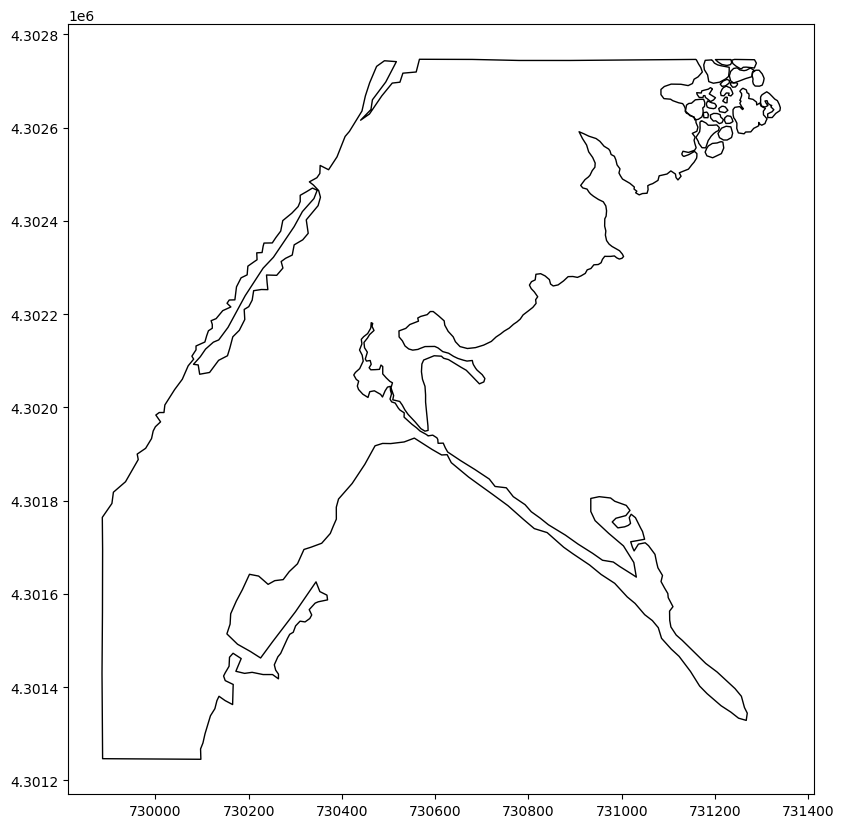

In [20]:
print(list(shape_file.loc[16, "geometry"].exterior.coords))
print(len(shape_file.loc[16, "geometry"].exterior.coords))
print(shape_file.loc[16, "geometry"])
shape_file.loc[16, "geometry"]
shape_file.plot(figsize=(10,10), edgecolor="k", facecolor="none") # color="green"

In [21]:
# geometry = [Point(getattr(point, "X"), getattr(point, "Y")) for point in points]
# print(type(geometry))

In [22]:
# # xy_points = pd.Series([Point(xy) for xy in zip(x_values, y_values)])
xy_points = gpd.GeoSeries(df.apply(lambda row: Point(row['X'], row['Y']), axis=1))

# Created random 50 point and found inside or outside the Ground Truth

In [23]:
random_indices = random.sample(range(len_data), 50)

random_points = [xy_points[index] for index in random_indices]
random_points_gdf = gpd.GeoDataFrame(geometry=random_points)

for i in range(50):
    random_points_gdf.at[i,"inside_polygon"] = any(xy_points[random_indices[i]].within(poly) for poly in shape_file['geometry'])
    print(f"Point {xy_points[random_indices[i]]} in {random_indices[i]}.index: {any(xy_points[random_indices[i]].within(poly) for poly in shape_file['geometry'])}")

print(type(random_points_gdf.loc[0, "inside_polygon"]))
random_points_gdf['inside_polygon'] = random_points_gdf["inside_polygon"].astype('int32')
print(random_points_gdf.dtypes)
# label = xy_points[:5].apply(lambda point: any(point.within(poly) for poly in shape_file["geometry"]))


Point POINT (731076.458 4301522.38) in 4233181.index: False
Point POINT (731066.354 4302467.279) in 7823394.index: False
Point POINT (730006.825 4301910.71) in 1821387.index: True
Point POINT (731314.695 4302096.603) in 7991073.index: False
Point POINT (731038.553 4302720.737) in 8950721.index: True
Point POINT (731028.037 4302721.126) in 8867085.index: True
Point POINT (731157.254 4301591.813) in 4322013.index: False
Point POINT (731069.406 4302659.182) in 8875267.index: True
Point POINT (730025.001 4301968.293) in 1893775.index: True
Point POINT (729917.789 4301787.782) in 1566243.index: True
Point POINT (730959.575 4301944.505) in 4789905.index: False
Point POINT (730851.567 4302266.57) in 7417723.index: True
Point POINT (731297.289 4301800.664) in 5262641.index: False
Point POINT (730580.009 4301860.302) in 3275813.index: False
Point POINT (730252.262 4301930.109) in 3081783.index: True
Point POINT (730939.618 4302108.453) in 7064450.index: False
Point POINT (731041.875 4302157.851

In [24]:
for i in range(df):
    df.at[i,"is_tree"] = any(xy_points[i].within(poly) for poly in shape_file['geometry'])
    
df['is_tree'] = df["is_tree"].astype('int32')


# Plot the selected 50 points and define them inside or outside

Point POINT (729947.047 4301402.637) in 211269.index: Inside
Point POINT (731256.136 4301974.55) in 5353039.index: Outside
Point POINT (730163.648 4302094.311) in 5563397.index: Inside
Point POINT (730820.346 4302422.293) in 7520585.index: Inside
Point POINT (730672.201 4302201.723) in 6971472.index: Inside
Point POINT (730231.92 4302255.963) in 5822048.index: Outside
Point POINT (731047.67 4301874.219) in 4816945.index: Outside
Point POINT (730258.59 4301676.873) in 2455483.index: Inside
Point POINT (730894.08 4302073.434) in 6930044.index: Outside
Point POINT (731377.982 4302500.269) in 8432709.index: Outside
Point POINT (730277.898 4301765.779) in 2812974.index: Inside
Point POINT (730997.865 4301859.898) in 4660113.index: Outside
Point POINT (730630.818 4302275.262) in 6524860.index: Inside
Point POINT (730619.378 4301841.721) in 3272940.index: Outside
Point POINT (731270.942 4301650.136) in 5056347.index: Outside
Point POINT (730332.521 4301563.661) in 2193979.index: Outside
Point

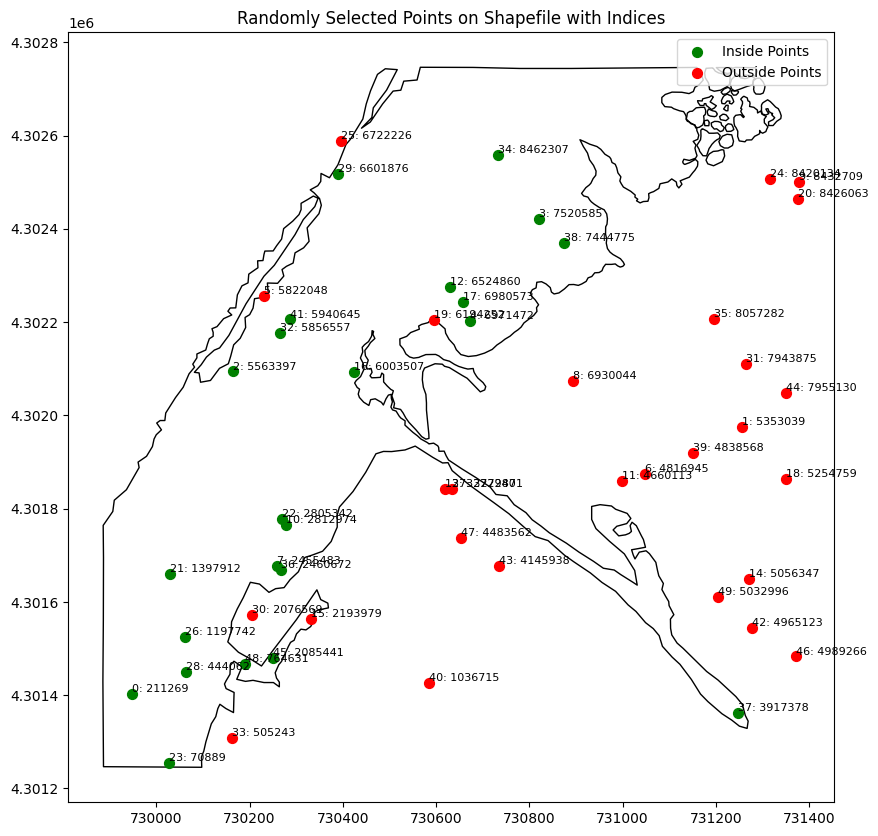

In [ ]:

# Build a spatial index for the shapefile
sindex = shape_file.sindex

# Find indices of points near each random point
nearby_point_indices = []
for random_point in random_points_gdf['geometry']:
    possible_matches_index = list(sindex.intersection(random_point.bounds))
    possible_matches = shape_file.iloc[possible_matches_index]
    nearest_point_index = possible_matches[possible_matches.intersects(random_point)].index
    nearby_point_indices.append(nearest_point_index)

# # Create a new column in random_points_gdf to indicate whether the points are inside or outside
# random_points_gdf['inside_polygon'] = [any(index in indices for indices in nearby_point_indices) for index in random_points_gdf.index]

# Print whether each point is inside or outside the polygons
for i, rand in enumerate(random_indices):
    is_inside = random_points_gdf.loc[i, 'inside_polygon']
    print(f"Point {xy_points[rand]} in {rand}.index: {'Inside' if is_inside else 'Outside'}")

# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
shape_file.plot(ax=ax, edgecolor='black', facecolor='none', aspect="equal")

# Plot the randomly selected points
random_points_gdf[random_points_gdf['inside_polygon'] == True].plot(ax=ax, color='green', marker='o', markersize=50, label='Inside Points')
random_points_gdf[random_points_gdf['inside_polygon'] == False].plot(ax=ax, color='red', marker='o', markersize=50, label='Outside Points')

lower_left_corner = df[(df['X'] == df['X'].min()) & (df['Y'] == df['Y'].min())]

# plt.plot(df[df["X"] == df["X"].max() and df["Y"] == df["Y"].min(), "X"], df[df['X'] == df["X"].max() and df["Y"] == df["Y"].min(),'Y'], marker="o", color="blue")
plt.plot(lower_left_corner["X"], lower_left_corner["Y"], marker="o", color="blue", markersize=50)
print(f"X: {df['X'].min()} Y: {df['Y'].min()}")


# Annotate the points with their indices
for i, point in enumerate(random_points_gdf['geometry']):
    ax.text(point.x, point.y, f"{i}: {random_indices[i]}", fontsize=8, ha='left', va='bottom')

# Add labels or legends if needed
plt.title('Randomly Selected Points on Shapefile with Indices')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
shape_file.plot(ax=ax, edgecolor='black', facecolor='none', aspect="equal")

# Plot the randomly selected points
df[df['is_tree'] == True].plot(ax=ax, color='green', marker='o', markersize=50, label='Inside Points')
df[df['is_tree'] == False].plot(ax=ax, color='red', marker='o', markersize=50, label='Outside Points')

lower_left_corner = df[(df['X'] == df['X'].min()) & (df['Y'] == df['Y'].min())]

# plt.plot(df[df["X"] == df["X"].max() and df["Y"] == df["Y"].min(), "X"], df[df['X'] == df["X"].max() and df["Y"] == df["Y"].min(),'Y'], marker="o", color="blue")
# plt.plot(lower_left_corner["X"], lower_left_corner["Y"], marker="o", color="blue", markersize=50)
# print(f"X: {df['X'].min()} Y: {df['Y'].min()}")


# Annotate the points with their indices
# for i, point in enumerate(random_points_gdf['geometry']):
#     ax.text(point.x, point.y, f"{i}: {random_indices[i]}", fontsize=8, ha='left', va='bottom')

# Add labels or legends if needed
plt.title('Randomly Selected Points on Shapefile with Indices')
plt.legend()

# Show the plot
plt.show()

Point POINT (1186790 1221198) in 5808351.index: Outside ??


False
POLYGON ((731159.6022082231 4302746.32885235, 731164.9930351551 4302736.181413422, 731169.4325396871 4302729.205049157, 731172.9207218193 4302719.374717694, 731163.7246052888 4302708.910171296, 731155.1627036917 4302703.836451832, 731151.6745215594 4302694.640335302, 731142.4784050295 4302690.20083077, 731126.9401391674 4302693.054797967, 731106.0110463747 4302693.371905436, 731091.4241029138 4302688.298185969, 731084.1306311822 4302681.956036639, 731084.130631182 4302670.857275309, 731090.4727805128 4302662.295373711, 731104.7426165083 4302661.026943846, 731109.499228507 4302657.855869179, 731121.8664197031 4302653.4163646465, 731130.7454287662 4302651.513719848, 731133.5993959655 4302647.074215317, 731135.819148232 4302642.634710786, 731136.7704706311 4302637.560991322, 731137.0875780974 4302635.024131588, 731145.0152647621 4302627.730659856, 731152.6258439588 4302623.608262792, 731158.9679932912 4302617.26611346, 731159.2851007573 4302610.923964128, 731163.4074978237 4302601.0

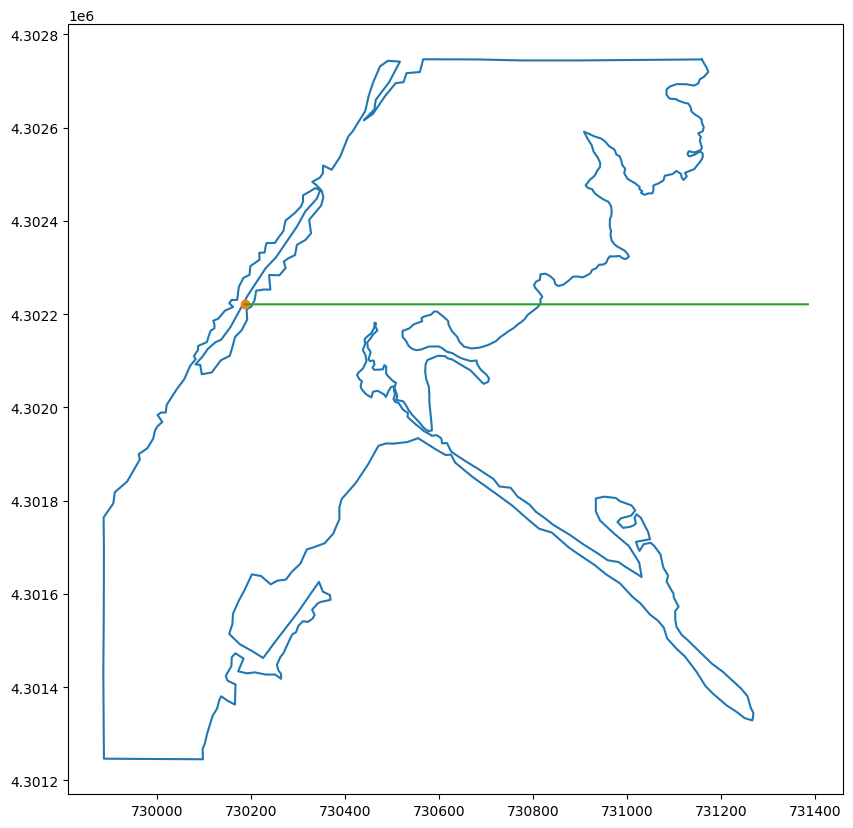

In [ ]:
print(xy_points[5808351].within(shape_file.loc[21, "geometry"]))
print(shape_file.loc[21, "geometry"])
# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
x, y = shape_file.loc[21,"geometry"].exterior.xy
plt.plot(x,y)
plt.plot(xy_points[5808351].x, xy_points[5808351].y, marker="o")
x = np.linspace(int(xy_points[5808351].x), int(las_max_x), int(las_max_x) - int(xy_points[5808351].x))
y = np.full((len(x)), xy_points[5808351].y)
plt.plot(x, y)
plt.show()


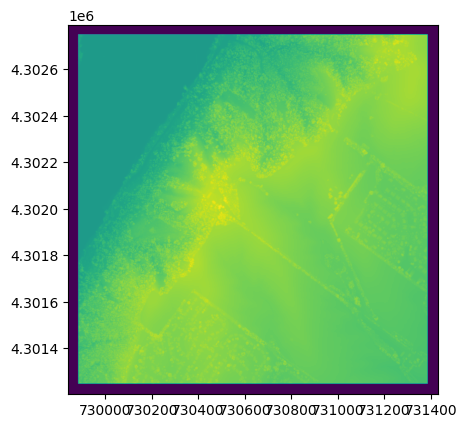

3175 3176
<class 'rasterio.io.DatasetReader'>
BoundingBox(left=729840.9373750874, bottom=4301202.786778949, right=731428.4373750874, top=4302790.786778949)
| 0.50, 0.00, 729840.94|
| 0.00,-0.50, 4302790.79|
| 0.00, 0.00, 1.00|
(729840.9373750874, 4302790.786778949)
(731428.4373750874, 4301202.786778949)
(3176, 3175)
0.0


In [ ]:

tif_file = rasterio.open("data/SaintLouisDSM/SaintLouisDSM.tif")
show(tif_file)
print(tif_file.width, tif_file.height)
print(type(tif_file))
print(tif_file.bounds)
print(tif_file.transform)
print(tif_file.transform * (0,0))
print(tif_file.transform * (tif_file.width, tif_file.height))
print(tif_file.read(1).shape) # returns numpy array
print(tif_file.read(1)[0,0])